In [316]:
import json
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [317]:
small_model_preds_path = "/home/haghigh/Documents/MIT_ENSEMBLE_SERVE/llama/exllama/certainties_7b_1000.json"
large_model_preds_path = "/home/haghigh/Documents/MIT_ENSEMBLE_SERVE/llama/exllama/certainties_13b_1000.json"
true_vals_path = "/home/haghigh/Documents/MIT_ENSEMBLE_SERVE/llama/exllama/true_vals_7b_1000.json"

with open(small_model_preds_path, 'r') as file:
    small_preds = json.load(file)

with open(large_model_preds_path, 'r') as file:
    large_preds = json.load(file)

with open(true_vals_path, 'r') as file:
    true_vals = json.load(file)

small_preds = np.array(small_preds)
large_preds = np.array(large_preds)
true_vals = np.array(true_vals)

In [318]:
def uncertainty_prb(softmax_output, alpha=.5):
    if max(softmax_output) < alpha:
        return 1
    else:
        return 0 

In [319]:
def uncertainty_ent(softmax_output, alpha=0.5):
    probabilities = np.exp(softmax_output) / np.sum(np.exp(softmax_output), axis=-1)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-2), axis=-1)
    # print(entropy)
    if entropy > alpha:
        return 1
    else:
        return 0

In [320]:
vec_funct = np.vectorize(lambda row: uncertainty_prb(row, 0.5), signature='(n)->()')
uncertainties_2 = vec_funct(small_preds)

In [325]:
def get_risk(alpha, regularization_strength=0.05):
    # compute uncertainty metric from the predictions made by the small model
    # uncertainties_small_model = np.apply_along_axis(uncertainty_prb(alpha), axis=1, arr=small_preds)

    # vec_funct = np.vectorize(lambda row: uncertainty_prb(row, alpha), signature='(n)->()')
    vec_funct = np.vectorize(lambda row: uncertainty_ent(row, alpha), signature='(n)->()')
    uncertainties_small_model = vec_funct(small_preds)
    
    # if uncertainty is larger than 0.5, cascade to large model 
    cascaded_samples = uncertainties_small_model > 0.5
    
    # intialize empty array for storing the predictions of the combined cascaded model 
    cascaded_preds = np.empty(true_vals.shape)
    
    # for samples that are cascaded, use prediction from large model
    cascaded_preds[cascaded_samples] = np.argmax(large_preds[cascaded_samples], axis=1)
    
    # for samples that are not cascaded, use prediction from small model 
    cascaded_preds[~cascaded_samples] = np.argmax(small_preds[~cascaded_samples], axis=1)
    
    # prediction loss is taken as 0-1 loss, where 0 is for correct prediction
    # and 1 is for incorrect prediction 
    prediction_loss = sum(true_vals != cascaded_preds)

    # print(accuracy_score(true_vals, cascaded_preds))
    
    small_model_comp_cost = 1
    large_model_comp_cost = 1.82
    
    # cost of compute is taken by combining how many times the large model needed to be ran and the small model being ran each time 
    computational_cost = sum(cascaded_samples) * large_model_comp_cost + len(cascaded_samples) * small_model_comp_cost
    
    empirical_risk = prediction_loss + regularization_strength * computational_cost

    accuracy = accuracy_score(true_vals, cascaded_preds)
    
    # return empirical_risk, computational_cost, prediction_loss
    
    return computational_cost / len(true_vals), accuracy 

In [329]:
# alphas for probability 
# alphas = np.linspace(0, 1, num=100)

# alphas for entropy
alphas = np.linspace(1.31,1.35,num=50)
# regularization_strengths = np.linspace(0,.3,num=10)

In [330]:
computational_costs = []
accuracies = []
for alpha in alphas:
    computational_cost, accuracy = get_risk(alpha)
    computational_costs.append(computational_cost)
    accuracies.append(accuracy)

Text(0.5, 1.0, 'Computational Cost vs. Accuracy')

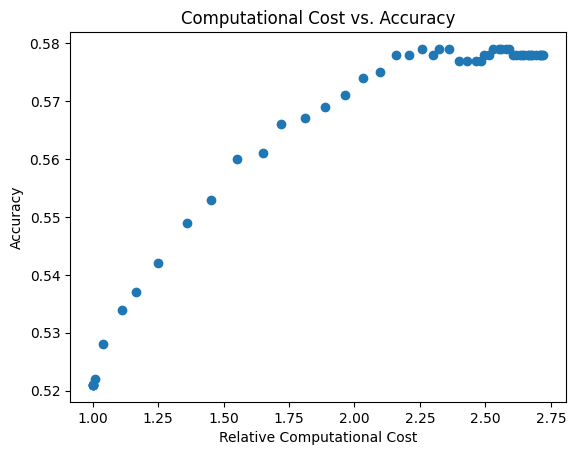

In [331]:
plt.scatter(computational_costs,accuracies)
plt.xlabel("Relative Computational Cost")
plt.ylabel("Accuracy")
plt.title("Computational Cost vs. Accuracy")

In [298]:
empirical_risks = []
for alpha in alphas:
    # for regularization_strength in regularization_strengths:
        # empirical_risks.append(get_risk(alpha, regularization_strength))
    empirical_risks.append(get_risk(alpha))

Text(0.5, 1.0, 'Empirical Risk vs. Alpha')

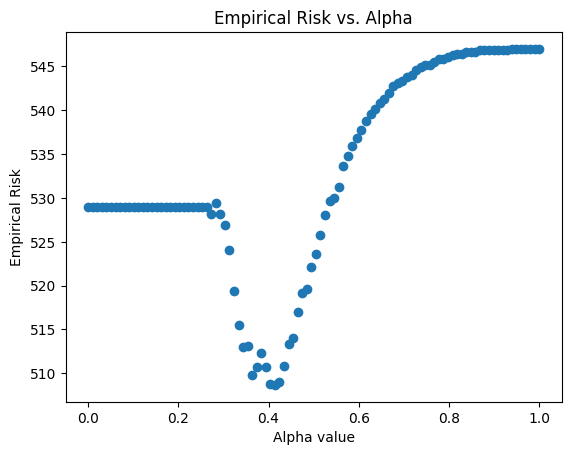

In [299]:
plt.scatter(alphas,empirical_risks)
plt.xlabel("Alpha value")
plt.ylabel("Empirical Risk")
plt.title("Empirical Risk vs. Alpha")

In [267]:
min_value = min(alphas, key=lambda x: get_risk(x))
print(min_value)

1.3475510204081633


In [268]:
min_risk = 1E5
alpha_at_min_risk = 0

for alpha in alphas:
    risk = get_risk(alpha)
    if risk < min_risk:
        min_risk = risk
        alpha_at_min_risk = alpha

In [269]:
min_risk

979.0

In [270]:
alpha_at_min_risk

1.3475510204081633

In [260]:
accuracy_score(true_vals, cascaded_preds)

0.52

In [261]:
accuracy_score(true_vals,np.argmax(large_preds, axis=1))

0.578